In [1]:
# Prepare model, data pre-processors and coordinate scalers

from tensorflow import keras
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import joblib

import sys
sys.path.insert(0, '/home/miguel/Projects/smlm_z/publication/')
from util.util import grid_psfs, load_dataset, save_dataset, load_model, preprocess_img_dataset

from tifffile import imread
import numpy as np

model_result_dir = '/home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/'
test_data_dir = '/media/Backup/smlm_z_data/20240612_miguel_zeiss/6um_50nm_AF_Readout_1'
test_case = '3um_50nm_AF_Readout_1_MMStack_Default.ome.tif'
key_frame_locs = '3um_50nm_AF_Readout_1_MMStack_Default_slice.ome_locs.hdf5'
comparison_data = f'{test_data_dir}/Z_list2.txt'
PIXEL_SIZE = 106
MIN_LOCS_PER_FRAME = 70
STACK = True
MIN_SNR = 1.5

im_size_nm = np.array(imread(os.path.join(test_data_dir, test_case)).shape[1:]) * PIXEL_SIZE


2024-08-23 14:48:17.964504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 14:48:17.964532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 14:48:17.964552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 14:48:17.969816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 14:48:18.596217: W tensorflow/compiler/

In [2]:
import pandas as pd
df2 = pd.read_hdf('/media/Backup/smlm_z_data/20240612_miguel_zeiss/6um_50nm_AF_Readout_1/combined/locs.hdf', key='locs')

In [3]:
df2['offset'].mean()/50

48.277704450662576

In [4]:
%matplotlib inline

(141, 121, 15, 15) (141, 16)
Using model dir from parameter -mo/--model-dir
/media/Backup/smlm_z_data/20240612_miguel_zeiss/6um_50nm_AF_Readout_1/combined/locs_merged.yaml
fov-max
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
(17061, 15) (17061, 15, 15)
Gen 2d plot
Gen example splots
Applying pre-processing
Coords value range: 0.019753158887227378 0.9869625854492188
9/9 [==============================] - 1s 20ms/step
Wrote results to:
	- /home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/out_stacks_20240612_miguel_zeiss_6um_50nm_AF_Readout_1/locs_3d.hdf5
	- /home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/out_stacks_20240612_miguel_zeiss_6um_50nm_AF_Readout_1/locs_3d.yaml


/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'z [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'x [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'y [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this obje

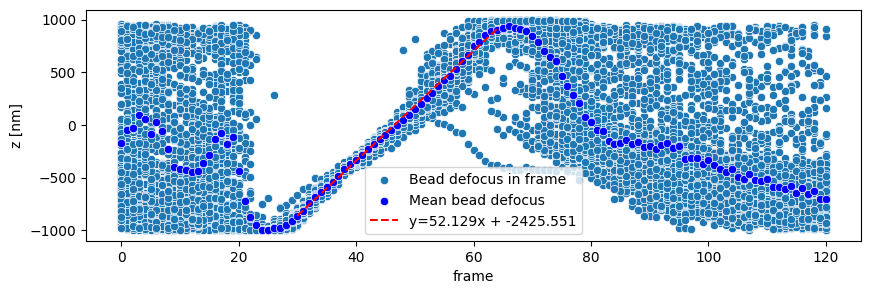

In [21]:
# Analyse dataset as bead stacks

from localise_exp_sample import main as loc_exp_sample_main, preprocess_args
import pandas as pd
import tensorflow as tf
import h5py

bead_stacks = os.path.join(test_data_dir, 'combined', 'stacks.ome.tif')
locs_stacks = os.path.join(test_data_dir, 'combined', 'locs.hdf')

bead_stacks = imread(bead_stacks)
locs_stacks = pd.read_hdf(locs_stacks, key='locs')
print(bead_stacks.shape, locs_stacks.shape)

locs_frames = []
rows = locs_stacks.to_dict(orient="records")
for i in range(bead_stacks.shape[0]):
    for i2 in range(bead_stacks.shape[1]):
        r = rows[i].copy()
        r['frame'] = i2
        locs_frames.append(r)
    # locs_frames.extend([rows[i]] * bead_stacks.shape[1])
locs_frames = pd.DataFrame.from_records(locs_frames)
bead_frames = np.concatenate(bead_stacks)

locs_path = os.path.join(test_data_dir, 'combined', 'locs_merged.hdf5')
del locs_frames['fname']
del locs_frames['rejected']
with h5py.File(locs_path, 'w') as f:
    f.create_dataset('locs', data=locs_frames.to_records())

spots_path = os.path.join(test_data_dir, 'combined', 'stacks_merged.hdf5')
with h5py.File(spots_path, 'w') as f:
    f.create_dataset('spots', data=bead_frames)

outdir_name = '_'.join(test_data_dir.split('/')[-2:])
outdir = os.path.join(model_result_dir, f'out_stacks_{outdir_name}')

args = {
    'locs': locs_path,
    'spots': spots_path,
    'outdir': outdir,
    'model_dir': model_result_dir,
    'picked_locs': None,
    # 'norm': norm,
    'pixel_size': PIXEL_SIZE,
    'sensitivity': 1,
    'gain': 1,
    'baseline': 100,
}

args = preprocess_args(args)
loc_exp_sample_main(args)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
df_path = os.path.join(outdir, 'locs_3d.hdf5')
df = pd.read_hdf(df_path, key='locs')

N_FRAMES = df['frame'].max()

df.reset_index(inplace=True)
sns.scatterplot(data=df, x='frame', y='z [nm]', label='Bead defocus in frame')

df2 = df.groupby('frame').mean()
sns.scatterplot(data=df2, x='frame', y='z [nm]', c='blue', label='Mean bead defocus')

start = 30
end = 65

x = df2.index
y = df2['z [nm]']
coef = np.polyfit(x[start:end], y[start:end], 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x[start:end], poly1d_fn(x[start:end]), '--r', label=f'y={round(coef[0], 3)}x + {round(coef[1], 3)}')
plt.legend()
plt.savefig('./autofocus_timelapse_stack.png')
plt.show()


In [7]:
%matplotlib inline

In [8]:
comp_df = pd.read_csv(comparison_data, names=['Z drive status', 'timestamp', 'defocus', 'stage position'])
comp_df['timestamp'] = pd.to_datetime(comp_df['timestamp'], format='ISO8601')
comp_df['timestamp'] = [x.timestamp() for x in comp_df['timestamp']]
comp_df['timestamp'] -= comp_df['timestamp'][0]
comp_df['frame'] = np.linspace(0, N_FRAMES, comp_df.shape[0])
comp_df['defocus'] *= -1000


In [61]:
from sklearn.linear_model import LinearRegression

# Recenter xy to 0, 0
df['x [nm]'] -= (im_size_nm[0]/2)
df['y [nm]'] -= (im_size_nm[1]/2)

def reduce_frame_planes(locs, min_snr=None):
    if min_snr is not None:
        locs = locs[locs['snr']>min_snr]
    frames = []
    zs = []
    errors = []
    
    xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
    pred_z = locs['z [nm]'].to_numpy()
    for frame in list(sorted(set(locs['frame']))):
        idx = np.argwhere(locs['frame']==frame).squeeze()
        if idx.size<4:
            # pred_frame_z_init.append(np.mean(pred_z[idx]))
            # pred_frame_z_refit.append(np.mean(pred_z[idx]))
            # print(f'Frame {frame} has insufficient locs')
            continue
        XY_data = xy_nm[idx]
        Z_data = pred_z.squeeze()[idx]
        reg = LinearRegression().fit(XY_data, Z_data)
              
        z_fit = reg.predict(XY_data)
        frame_err = abs(z_fit - Z_data)
        zs.append(reg.intercept_)
        errors.append(np.mean(frame_err))
        frames.append(frame)
    return np.array(frames), np.array(zs), np.array(errors)

frames, zs, errors = reduce_frame_planes(df)
                      

# plt.figure(figsize=(5,5))
# sns.scatterplot(data=locs, x='x [nm]', y='y [nm]')

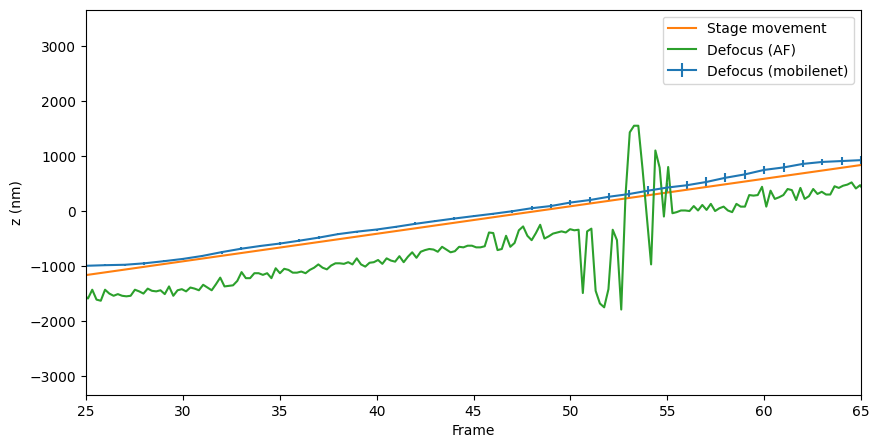

In [62]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=frames, y=zs, yerr=errors, label='Defocus (mobilenet)')

x_stage = np.array([15, 70])
y_stage = list(map(lambda x: (50 * x) - 2413.885222533129, x_stage))
plt.plot(x_stage, y_stage, label='Stage movement')
sns.lineplot(data=comp_df, x='frame', y='defocus', label='Defocus (AF)')

plt.legend()
plt.xlim((25, 65))
plt.xlabel('Frame')
plt.ylabel('z (nm)')
plt.savefig('./af_stack_experiment.png')
plt.show()


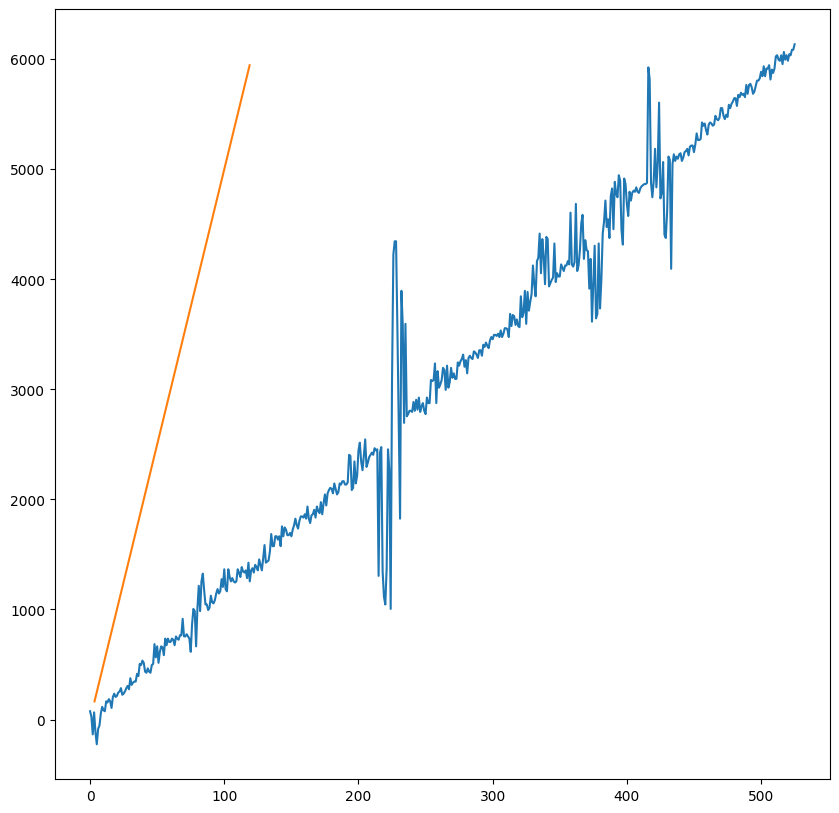

167.31932200158778


In [80]:
z_vals = comp_df['defocus'].to_numpy()[15:-5]
x_vals = comp_df['frame'].to_numpy()[15:-5]
# z_vals = zs[25:65].copy()
# x_vals = np.arange(z_vals.shape[0])

from scipy import optimize as opt
from sklearn.metrics import mean_absolute_error

def linfit(x, c):
    return (x*50) + c

popt, _ = opt.curve_fit(linfit, x_vals, z_vals, p0=-2500)

z_vals -= popt[0]

plt.plot(z_vals)
plt.plot(x_vals, x_vals*50)
plt.show()

errors = mean_absolute_error(z_vals, x_vals * 50)
print(errors)
# def bestfit_error(z_true, z_pred):


#     x = z_true
#     y = z_pred
#     popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

#     x = np.linspace(z_true.min(), z_true.max(), len(y))
#     y_fit = linfit(x, popt[0])
#     error = mean_absolute_error(y_fit, y)
#     return error, popt[0], y_fit, abs(y_fit - y)
    
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression(

In [26]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from skimage.transform import resize
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# def mean_squared_error(x, y):
#     err = np.mean((x-y)**2)
#     return err

# def reduce_img(stack):
#     return stack.max(axis=(1,2))


    
def get_lat_fwhm(image, px_size_xy, debug=False, mse_thres=0.001):
    def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        x, y = xy
        xo = float(xo)
        yo = float(yo)
        a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
        b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
        c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
        g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
        return g.ravel()

    # Load and preprocess the image (e.g., convert to grayscale)
    # For simplicity, let's generate a simple image for demonstration
    image_size = image.shape[1]
    x = np.linspace(0, image_size - 1, image_size)
    y = np.linspace(0, image_size - 1, image_size)
    x, y = np.meshgrid(x, y)
    
    image = image / image.max()

    # Fit the Gaussian to the image data
    p0 = [1, image_size / 2, image_size / 2, 2, 2, 0, 0]  # Initial guess for parameters
    bounds = [
        (0, np.inf),
        (image_size * (1/5), image_size * (4/5)),
        (image_size * (1/5), image_size * (4/5)),
        (0, image_size/3),
        (0, image_size/3),
        (-np.inf, np.inf),
        (0, np.inf),
    ]

    try:
        popt, pcov = curve_fit(gaussian_2d, (x, y), image.ravel(), p0=p0, bounds=list(zip(*bounds)))
    except RuntimeError as e:
        popt = p0
    render = gaussian_2d((x, y), *popt).reshape(image.shape)

    error = mean_squared_error(render, image)
    # if error > mse_thres:
    #     fwhm_x, fwhm_y =  np.nan, np.nan
    # else:
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt
    f = 2 * np.sqrt(2 * np.log(2))
    fwhm_x = sigma_x * f * px_size_xy
    fwhm_y = sigma_y * f * px_size_xy
    fwhm_xy = np.mean([fwhm_x, fwhm_y])


    if debug:
        plt.figure(figsize=(2,2))
        print('FWHM x:', round(fwhm_x, 3), 'nm')
        print('FWHM y:', round(fwhm_y, 3), 'nm')
        print('MSE   :', '{:.2e}'.format(error))
        plt.imshow(image)
        plt.show()
        print('\n')
    return fwhm_xy, error

from tqdm import trange

stack_fwhms = np.array([[get_lat_fwhm(img, 106) for img in stack] for stack in tqdm(bead_stacks)])

print(stack_fwhms.shape)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [03:39<00:00,  1.56s/it]

(141, 121, 2)


In [28]:
def snr(img):
    return img.max() / img.mean()

stack_snr = np.array([[snr(img) for img in stack] for stack in tqdm(bead_stacks)])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 1726.62it/s]


In [85]:
stack_photons = np.array([[img.sum() for img in stack] for stack in tqdm(bead_stacks)])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 5110.36it/s]


In [87]:
stack_photons.shape

(141, 121)

In [49]:
def get_offset(stack):
    return np.argmax(stack.max(axis=(1,2))) * 50

offsets = [get_offset(s) for s in bead_stacks]

In [89]:
z = np.arange(bead_stacks.shape[1]) * 50
zs = np.array([[z-o] for o in offsets])


In [90]:
print(stack_fwhms.shape, stack_snr.shape, zs.shape, stack_photons.shape)

(141, 121, 2) (141, 121) (141, 1, 121) (141, 121)


In [91]:
df_bead_stack = pd.DataFrame.from_dict({
    'fwhm': stack_fwhms[:, :, 0].flatten(),
    'z': zs.flatten(),
    'snr': stack_snr.flatten(),
    'photons': stack_photons.flatten()
})

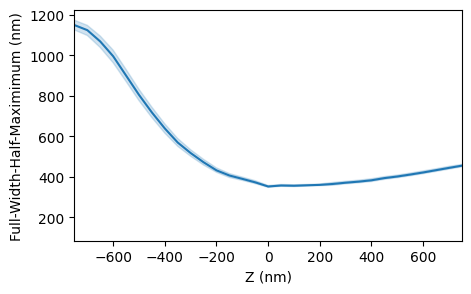

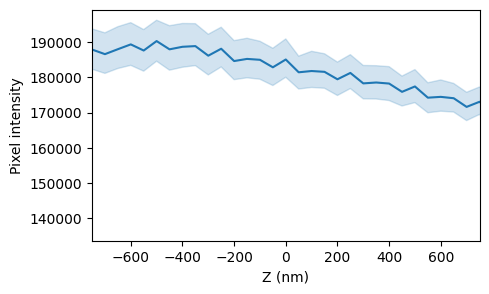

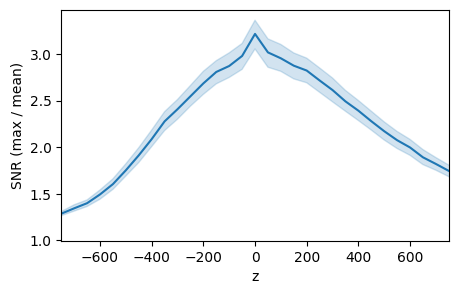

In [92]:
plt.figure(figsize=(5,3))
sns.lineplot(data=df_bead_stack, x='z', y='fwhm')
plt.xlim((-750, 750))
plt.xlabel('Z (nm)')
plt.ylabel('Full-Width-Half-Maximimum (nm)')
plt.savefig('./autofocus_fwhm_training_data.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,3))
sns.lineplot(data=df_bead_stack, x='z', y='photons')
plt.xlim((-750, 750))
plt.xlabel('Z (nm)')
plt.ylabel('Pixel intensity')
plt.savefig('./autofocus_px_intensity_training_data.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(5,3))
sns.lineplot(data=df_bead_stack, x='z', y='snr')
plt.xlim((-750, 750))
plt.ylabel('SNR (max / mean)')
plt.savefig('./autofocus_snr_training_data.png', bbox_inches='tight')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import shutil
from localise_exp_sample import main as loc_exp_sample_main, preprocess_args

test_fpath = os.path.join(test_data_dir, test_case)

locs_path = test_fpath.replace('.tif', '_locs.hdf5')
spots_path = test_fpath.replace('.tif', '_spots.hdf5')
outdir_name = '_'.join(test_data_dir.split('/')[-2:])
outdir = os.path.join(model_result_dir, f'timelapse_{outdir_name}')
os.makedirs(outdir, exist_ok=True)
args = {
    'locs': locs_path,
    'spots': spots_path,
    'outdir': outdir,
    'model_dir': model_result_dir,
    'picked_locs': None,
    # 'norm': norm,
    'pixel_size': PIXEL_SIZE,
    'sensitivity': 1,
    'gain': 1,
    'baseline': 100
}
args = preprocess_args(args)
loc_exp_sample_main(args)

locs_path = os.path.join(args['outdir'], 'locs_3d.hdf5')
locs = pd.read_hdf(locs_path, key='locs')


print('Loading', locs_path)


In [ ]:
# Filter timelapse locs so only those in key frame are kept
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances

with h5py.File(spots_path) as f:
    spots = np.array(f['spots'])

    
key_frame_df = pd.read_hdf(os.path.join(test_data_dir, key_frame_locs), key='locs')

print(key_frame_df.shape)
key_frame_df = dfs[dfs['corrcoef']>0.9]
print(key_frame_df.shape)

key_frame_df = key_frame_df.groupby(['x', 'y']).sum().reset_index()
plt.figure(figsize=(3,3))
sns.scatterplot(data=key_frame_df, x='x', y='y', label='key-frame')
sns.scatterplot(data=locs, x='x', y='y', label='timelapse', marker='.')
plt.legend()
plt.show()
print(locs.shape)

locs_xy = locs[['x', 'y']].to_numpy()
key_frame_xy = key_frame_df[['x', 'y']].to_numpy()

dists = euclidean_distances(locs_xy, key_frame_xy)
threshold = 5

idx = np.argwhere(dists.min(axis=1)<threshold)[:, 0]
print(f'Kept {len(idx)} from {locs.shape[0]}')
locs = locs.iloc[idx]
spots = spots[idx]
locs['spot_id'] = np.arange(spots.shape[0])

locs['closest_key_loc'] = dists[idx].argmin(axis=1).astype(str)

plt.figure(figsize=(3,3))
sns.scatterplot(data=key_frame_df, x='x', y='y', label='key-frame')
sns.scatterplot(data=locs, x='x', y='y', label='timelapse', marker='.')
plt.legend()
plt.show()





In [ ]:
sns.scatterplot(data=locs, x='frame', y='x')
plt.show()

In [ ]:
plt.figure(figsize=(5,3))
df2 = locs.groupby('frame').count()
sns.scatterplot(data=df2, x='frame', y='z [nm]')
plt.ylabel('Number of beads in frame')

In [ ]:
tmp_df = locs[(locs['frame']>40)&(locs['frame']<80)]
tmp_df['frame_nm'] = tmp_df['frame'] * 50
for l in tmp_df['closest_key_loc']:
    plt.figure(figsize=(10,3))
    tmp_df2 = tmp_df[tmp_df['closest_key_loc']==l]

    spot_ids = tmp_df2['spot_id'].to_numpy()
    tmp_spots = spots[spot_ids]
    show_psf_axial(tmp_spots, '', 1)
    x = tmp_df2['frame'].to_numpy().astype(float)
    y = tmp_df2['z [nm]'].to_numpy().astype(float)
    # x -= x.mean()
    y -= y.mean()

    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)

    plt.figure(figsize=(10,3))

    errors = abs(poly1d_fn(x) - y)
    idx = np.argwhere(errors<100)[:, 0]
    x2 = x[idx]
    y2 = y[idx]
    coef = np.polyfit(x2, y2, 1)
    poly1d_fn = np.poly1d(coef)

    
    plt.plot(x, poly1d_fn(x), '--k', label=f'y={round(coef[0], 3)}x + {round(coef[1], 3)}')

    sns.lineplot(x=x, y=y, marker='o')
    plt.show()


In [ ]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns


def snr(x):
    return x.max() / x.mean()

z_preds = locs['z [nm]']
print(spots.shape)
inten = spots.max(axis=(1,2))
mean = spots.mean(axis=(1,2))
snrs = np.array([snr(x) for x in spots])
locs['snr'] = snrs
df = pd.DataFrame.from_dict({'frame': locs['frame'], 'z [nm]': locs['z [nm]'], 'z_pred': z_preds, 'means': mean, 'inten': inten, 'snr': snrs})

# plt.figure(figsize=(3,3))
# sns.kdeplot(data=df, x='z_pred', y='means', label='means')
# sns.kdeplot(data=df, x='z_pred', y='inten', label='inten')
# # sns.kdeplot(x=z_preds, y=inten, label='max')
# # sns.kdeplot(x=z_preds, y=mean, label='mean')
# plt.xlabel('Z pred')
# plt.ylabel('Max / mean pixel value')
# plt.legend()
# plt.show()

# plt.figure(figsize=(3,3))
# sns.kdeplot(data=df, x='z_pred', y='snr')
# plt.show()

import os
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
sns.scatterplot(data=df, x='frame', y='z [nm]', marker='.', hue='snr')

df2 = df.groupby('frame').mean()
sns.scatterplot(data=df2, x='frame', y='z [nm]', marker='+', c='blue')
plt.xlabel('Frame')
plt.ylabel('Pred z (nm)')
plt.show()


In [ ]:
# plt.figure(figsize=(5,5))
# sns.scatterplot(data=locs, x='x', y='y')
locs['x [nm]'] = locs['x'] * 106
locs['y [nm]'] = locs['y'] * 106
# plt.show()
# plt.figure(figsize=(5,5))

# sns.scatterplot(data=locs, x='x [nm]', y='y [nm]')

In [ ]:
# Recenter xy to 0, 0
locs['x [nm]'] -= (im_size_nm[0]/2)
locs['y [nm]'] -= (im_size_nm[1]/2)


# plt.figure(figsize=(5,5))
# sns.scatterplot(data=locs, x='x [nm]', y='y [nm]')

In [ ]:
# Fit plane, remove outliers and re-fit plane
from sklearn.linear_model import LinearRegression
import seaborn as sns
from data.visualise import grid_psfs
import numpy as np



xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
pred_z = locs['z [nm]'].to_numpy()

def reduce_frame_planes(locs, min_snr=None):
    if min_snr is not None:
        locs = locs[locs['snr']>min_snr]
    frames = []
    pred_frame_z_init = []
    pred_frame_z_refit = []
    frame_errors = []
    n_locs_frame = []
    for frame in list(sorted(set(locs['frame']))):
        idx = np.argwhere(locs['frame']==frame).squeeze()
        if idx.size<4:
            # pred_frame_z_init.append(np.mean(pred_z[idx]))
            # pred_frame_z_refit.append(np.mean(pred_z[idx]))
            # print(f'Frame {frame} has insufficient locs')
            continue
        XY_data = xy_nm[idx]
        Z_data = pred_z.squeeze()[idx]
        reg = LinearRegression().fit(XY_data, Z_data)
              
        pred_frame_z_init.append(reg.intercept_)
    
        
        z_fit = reg.predict(XY_data)
        errors = abs(z_fit - Z_data)
        # if frame == 550:
        #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
        #     plt.show()
    
    
        # if abs(frame-50) < 10:
        #     print(reg.__dict__)
        #     x, y = np.meshgrid(np.linspace(xy_nm[:, 0].min(), xy_nm[:, 0].max(), 10), np.linspace(xy_nm[:, 1].min(), xy_nm[:, 1].max(), 10))
        #     xy2 = np.vstack((x.flatten(), y.flatten())).T
        #     z = reg.predict(XY_data)
        #     error = z-Z_data
        #     plt.figure(figsize=(3,3))
        #     plt.scatter(x=XY_data[:, 0], y=XY_data[:, 1], c=error)
        #     plt.colorbar()
        #     plt.show()
    
        idx = np.argwhere(errors<500).squeeze()
        
        XY_data = XY_data[idx]
        Z_data = Z_data[idx]
        
        reg = LinearRegression().fit(XY_data, Z_data)
        
        
        residual = reg.predict(XY_data)
        res_error = np.std(residual / 1000)
    
        if len(idx) < 70:
            z = np.nan
        else:
            z = reg.intercept_
    
        frames.append(frame)
        pred_frame_z_refit.append(z)
        frame_errors.append(res_error)
        n_locs_frame.append(len(idx))

    pred_frame_z_init = np.array(pred_frame_z_init)
    
    pred_frame_z_refit = np.array(pred_frame_z_refit)
    pred_frame_z_init = (pred_frame_z_init - np.nanmean(pred_frame_z_init)) / 1000
    
    pred_frame_z_refit_um = (pred_frame_z_refit - np.nanmean(pred_frame_z_refit)) / 1000
    frames = np.array(frames)
    errors = np.array(frame_errors)
    
    def polyfit_1d(x, y, ax):
        idx = ~np.isnan(y)
        x2 = x[idx]
        y2 = y[idx]
        coef = np.polyfit(x2, y2, 1)
        poly1d_fn = np.poly1d(coef)
        ax.plot(x2, poly1d_fn(x2), '--', label=f'y={coef[0]:.5f}x + {coef[1]:.2f}')
        ax.legend()

    fig, ax1 = plt.subplots(figsize=(10,3))
    ax2 = ax1.twinx()
    ax1.scatter(frames, pred_frame_z_refit_um*1000)
    polyfit_1d(frames, pred_frame_z_refit_um*1000, ax1)
    ax2.plot(frames, n_locs_frame, c='red', label='N locs')
    ax2.legend()
    ax2.set_ylabel('N locs in frame')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Defocus (nm)')
    
    
    
    
    return frames, pred_frame_z_init, pred_frame_z_refit_um, errors

for min_snr in [1, 1.25, 1.5, 1.75, 2, 2.5]:
    try:
        reduce_frame_planes(locs, min_snr)
        plt.title(f'min_snr {min_snr}')
        
        plt.show()
    except Exception as e:
        print(e)


min_snr = 1
frames, pred_frame_z_init, pred_frame_z_refit_um, errors = reduce_frame_planes(locs, min_snr=min_snr)
plt.title(f'min_snr {min_snr}')
plt.show()

In [ ]:
from scipy.stats import pearsonr

plt.figure(figsize=(10,3))


from scipy.ndimage import gaussian_filter1d

start, end = 35, 60

sub_frames = frames[start:end]

y = pred_frame_z_refit_um * 1000
sub_y = y[start:end]
sub_errors = errors[start:end]
# y = gaussian_filter1d(y, 5)


plt.errorbar(sub_frames, sub_y, sub_errors * 1000, alpha=0.25, label='stDev of residual to plane fit')
plt.plot(sub_frames, sub_y)
# plt.scatter(frames, pred_frame_z_refit_um)

idx = np.isnan(sub_y)
sub_frames = sub_frames[~idx]
sub_y = sub_y[~idx]
coef = np.polyfit(sub_frames, sub_y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(sub_frames, poly1d_fn(sub_frames), '--k', label=f'y={round(coef[0], 3)}x + {round(coef[1], 3)}')


plt.legend()
plt.xlabel('Frames')
plt.ylabel('Defocus (nm)')
plt.show()

In [ ]:
# For timelapse-stack

import numpy as np
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(10, 5))



comp_df = pd.read_csv(comparison_data, names=['Z drive status', 'timestamp', 'defocus', 'stage position'])
comp_df['timestamp'] = pd.to_datetime(comp_df['timestamp'], format='ISO8601')
comp_df['timestamp'] = [x.timestamp() for x in comp_df['timestamp']]
comp_df['timestamp'] -= comp_df['timestamp'][0]
comp_df['frame'] = np.linspace(0, N_FRAMES, comp_df.shape[0])

comp_df['stage position'] -= comp_df['stage position'].mean()
for c in ['stage position', 'defocus']:
    comp_df[c] = gaussian_filter1d(comp_df[c], sigma=25)

comp_df['defocus'] *= -1
# for status in ['Z_ON', 'Z_OFF']:
#     tmp_df = comp_df[comp_df['Z drive status']==status]
#     plt.plot(tmp_df['frame'], tmp_df['stage position'] * 1000, label=f'Stage position ({status})')

# Vertical line
switch_idx = np.argwhere((comp_df['Z drive status'].to_numpy()[:-1] != comp_df['Z drive status'].to_numpy()[1:]))
switch_frame = comp_df['frame'].to_numpy()[switch_idx]
ymin = comp_df[['defocus', 'stage position']].to_numpy().min()
ymax = comp_df[['defocus', 'stage position']].to_numpy().max()
plt.vlines([switch_frame], label='AF turns off', ymin=ymin, ymax=ymax, color='purple')

mbnet_frames = sub_frames
mbnet_y_um = sub_y

plt.plot(mbnet_frames, mbnet_y_um-mbnet_y_um.mean(), label='Defocus (MobileNet)')
coef = np.polyfit(mbnet_frames, mbnet_y_um, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(mbnet_frames, poly1d_fn(mbnet_frames), '--k', label=f'y={round(coef[0], 3)}x + {round(coef[1], 3)}')
errors = abs(poly1d_fn(mbnet_frames)-mbnet_y_um)
# plt.show()

# plt.figure(figsize=(10, 5))
plt.plot(comp_df['frame'], (comp_df['defocus']-comp_df['defocus'].mean()) * 1000, label='Defocus (AF)')
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.legend()
plt.show()
print('Assumptions:')
print('\t- Timelapse / AF readouts scaled to cover same duration')
print('\t- Defocus (AF) is inverted')
print(f'Effective range: {sub_y.min():.2f} - {sub_y.max():.2f}nm')
print(f'Approximate error: mean: {np.mean(errors):.2f}nm - stdev {np.std(errors):.2f}nm')
plt.figure(figsize=(5,3))
sns.histplot(errors, stat='density')
plt.xlabel('Error (nm)')
plt.show()

In [ ]:
sub_comp_df = comp_df[(comp_df['frame'] > 20) & (comp_df['frame'] < 100)]
sub_comp_df['af_error'] = sub_comp_df['defocus'] - sub_comp_df['stage position']

coef = np.polyfit(sub_comp_df['frame'], sub_comp_df['stage position']*1000, 1)
poly1d_fn = np.poly1d(coef)
nn_error = sub_y-poly1d_fn(sub_frames)



plt.figure(figsize=(5,3))
# plt.plot(sub_comp_df['frame'], sub_comp_df['af_error']*1000)
plt.plot(sub_frames, nn_error-nn_error.mean(), label='neuralnet')
plt.plot(sub_comp_df['frame'], (sub_comp_df['af_error']-sub_comp_df['af_error'].mean())*1000, label='af_error')
plt.xlabel('Frame')
plt.ylabel('Error (nm)')
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.boxplot([abs(nn_error-nn_error.mean()), abs(sub_comp_df['af_error']-sub_comp_df['af_error'].mean())*1000], labels=['nnet', 'AF'])
plt.ylabel('abs. Error (nm)')
plt.show()

In [ ]:
# For timelapse

import numpy as np
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(10, 5))

# frames = df['frame']
# plt.scatter(x=df2.index, y=df2['z [nm]']/1000, c='blue')
# # sns.scatterplot(data=df2, x='frame', y='z [nm]', c='blue')


comp_df = pd.read_csv(comparison_data, names=['Z drive status', 'timestamp', 'defocus', 'stage position'])
comp_df['timestamp'] = pd.to_datetime(comp_df['timestamp'], format='ISO8601')
comp_df['timestamp'] = [x.timestamp() for x in comp_df['timestamp']]
comp_df['timestamp'] -= comp_df['timestamp'][0]
comp_df['timestamp'] = np.linspace(0, max(frames), comp_df.shape[0])

comp_df['stage position'] -= comp_df['stage position'].to_numpy()[-1]
for c in ['stage position', 'defocus']:
    comp_df[c] = gaussian_filter1d(comp_df[c], sigma=25)

comp_df['defocus'] *= -1
for status in ['Z_ON', 'Z_OFF']:
    tmp_df = comp_df[comp_df['Z drive status']==status]
    plt.plot(tmp_df['timestamp'], tmp_df['stage position'], label=f'Stage position ({status})')

plt.plot(z_nm, y/1000, label='Defocus (MobileNet)')


# plt.show()

# plt.figure(figsize=(10, 5))
plt.plot(comp_df['timestamp'], comp_df['defocus']-comp_df['defocus'].mean(), label='Defocus (AF)')
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.legend()
plt.show()
print('Assumptions:')
print('\t- Timelapse / AF readouts scaled to cover same duration')
print('\t- Defocus (AF) is inverted')




In [ ]:
df_count = locs[locs['snr']>=1.25].groupby('frame').count()

plt.plot(df_count.index, df_count['x'])

In [ ]:
frame_switch = int(np.mean(frames))

print('AF On version')
frames_on = frames[:frame_switch]
pred_frame_z_refit_on = pred_frame_z_refit_um[:frame_switch]
sns.scatterplot(x=frames_on, y=pred_frame_z_refit_on*1000, label='refit plane fit', ax=ax)
ax.set_ylabel('Defocus (um)')
ax.set_xlabel('Frame')
# ax.plot(comp_df_af_on['time stamp'], -comp_df_af_on['Defocus/um'], color='orange', label='Autofocus')
ax.legend(loc=0)
ax.legend(loc=2)
plt.show()


fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)

print('AF Off version')
frames_off = frames[frame_switch:]
pred_frame_z_refit_off = pred_frame_z_refit_um[frame_switch:]
sns.scatterplot(x=frames_off, y=pred_frame_z_refit_off, label='refit plane fit', ax=ax)
ax.set_ylabel('Defocus (um)')
ax.set_xlabel('Frame')
# ax.plot(comp_df_af_off['time stamp'], comp_df_af_off['Defocus/um'], color='orange', label='Autofocus')
ax.legend(loc=0)
plt.show()

In [ ]:
# Manual cutoff

onoff_cutoff = int(locs['frame'].max()/2)

# Fit plane, remove outliers and re-fit plane
from sklearn.linear_model import LinearRegression
import seaborn as sns
from data.visualise import grid_psfs
import numpy as np


frames = []
pred_frame_z_init = []
pred_frame_z_refit = []
xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
pred_z = locs['z [nm]'].to_numpy()
for frame in list(sorted(set(locs['frame']))):
    idx = np.argwhere(locs['frame']==frame).squeeze()
    if idx.size<4:
        # pred_frame_z_init.append(np.mean(pred_z[idx]))
        # pred_frame_z_refit.append(np.mean(pred_z[idx]))
        print(f'Frame {frame} has insufficient locs')
        continue
    XY_data = xy_nm[idx]
    Z_data = pred_z.squeeze()[idx]
    reg = LinearRegression().fit(XY_data, Z_data)
    pred_frame_z_init.append(reg.intercept_)

    
    z_fit = reg.predict(XY_data)
    errors = abs(z_fit - Z_data)
    # if frame == 550:
    #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
    #     plt.show()
    cutoff = np.percentile(errors, 75)
    idx = np.argwhere(errors<cutoff).squeeze()
    
    XY_data = XY_data[idx]
    Z_data = Z_data[idx]
    
    reg = LinearRegression().fit(XY_data, Z_data)

    frames.append(frame)
    pred_frame_z_refit.append(reg.intercept_)

plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=frames[:onoff_cutoff], y=pred_frame_z_refit[:onoff_cutoff])
plt.title('AF on')
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
sns.histplot(pred_frame_z_refit[:onoff_cutoff])
plt.title('Defocus (um) frequency while AF on')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=frames[onoff_cutoff:], y=pred_frame_z_refit[onoff_cutoff:])
plt.title('AF off')
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.show()


In [ ]:
# Comparison without autofocus 
# Fit plane, remove outliers and re-fit plane
from sklearn.linear_model import LinearRegression
import seaborn as sns
from data.visualise import grid_psfs
import numpy as np


frames = []
pred_frame_z_init = []
pred_frame_z_refit = []
xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
pred_z = locs['z [nm]'].to_numpy()
for frame in list(sorted(set(locs['frame']))):
    idx = np.argwhere(locs['frame']==frame).squeeze()
    if idx.size<4:
        # pred_frame_z_init.append(np.mean(pred_z[idx]))
        # pred_frame_z_refit.append(np.mean(pred_z[idx]))
        print(f'Frame {frame} has insufficient locs')
        continue
    XY_data = xy_nm[idx]
    Z_data = pred_z.squeeze()[idx]
    reg = LinearRegression().fit(XY_data, Z_data)
    pred_frame_z_init.append(reg.intercept_)

    
    z_fit = reg.predict(XY_data)
    errors = abs(z_fit - Z_data)
    # if frame == 550:
    #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
    #     plt.show()
    cutoff = np.percentile(errors, 75)
    idx = np.argwhere(errors<cutoff).squeeze()
    
    XY_data = XY_data[idx]
    Z_data = Z_data[idx]
    
    reg = LinearRegression().fit(XY_data, Z_data)

    frames.append(frame)
    pred_frame_z_refit.append(reg.intercept_)

pred_frame_z_refit_um = (pred_frame_z_refit - pred_frame_z_refit[0]) / 1000
frames = np.array(frames)

plt.figure(figsize=(10, 5), dpi=80)
plt.scatter(frames, pred_frame_z_refit_um)
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.show()

In [ ]:

training_data = imread(os.path.join('/home/miguel/Projects/smlm_z/autofocus/VIT_autofocus2/stacks.ome.tif')).astype(float)
training_data = norm_psf_frame(training_data)


In [ ]:
# Comparison data
import numpy as np
from tifffile import imread
def get_img_gradient(img):
    return np.sum(img)
    gy, gx = np.gradient(img)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def norm_psf_frame(psfs):
    for i in range(psfs.shape[0]):
        psf_min = psfs[i].min(axis=(1,2), keepdims=True)
        psfs[i] -= psf_min
        psf_max = psfs[i].max(axis=(1,2), keepdims=True)
        psfs[i] /= psf_max
    psfs[psfs<0] = 0
    return psfs
    
def get_stack_gradient(stack):
    return np.array([get_img_gradient(s) for s in stack])

for s in training_data[0:10]:
    plt.plot(np.arange(s.shape[0])*10, get_stack_gradient(s))
plt.show()


norm_spots = norm_psf_frame(spots).squeeze()
spots_gradient = get_stack_gradient(norm_spots)

frame_grads = []
for frame in set(locs['frame']):
    idx = np.argwhere(locs['frame']==frame).squeeze()
    grads = spots_gradient[idx]
    frame_grads.append(grads)

fig, ax1 = plt.subplots()

ax1.scatter(x=frames+1, y=[np.mean(x) for x in frame_grads], label='mean gradient', color='red', marker='x')
ax1.set_ylabel('Mean of sum(gradient) in normalised images')
plt.xlabel('Frame')
# plt.show()

ax2 = ax1.twinx()
ax2.scatter(x=frames+1, y=pred_frame_z_refit, label='refit plane fit', color='blue', marker='.')
ax2.legend(loc=0)
ax1.legend(loc=2)
plt.xlabel('Frame of time-lapse')
ax2.set_ylabel('Defocus / Z position (nm)')
plt.show()

In [ ]:
frame = 550
idx = np.argwhere(locs['frame']==frame).squeeze()

XY_data = xy_nm[idx]
Z_data = pred_z.squeeze()[idx][:, np.newaxis]

print(XY_data.shape)
print(Z_data.shape)

points = np.concatenate((XY_data, Z_data), axis=1)
data_mean = np.mean(points, axis=0)
data_centered = points - data_mean
U, S, Vt = np.linalg.svd(data_centered)
normal = Vt[-1, :]
d = -np.dot(normal, data_mean)

# Calculate the plane equation coefficients
a, b, c = normal
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2, c='b')

# Create a meshgrid for the plane
x_plane = np.linspace(-2, 2, 100)
y_plane = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_plane, y_plane)
Z = (-normal[0] * X - normal[1] * Y - d) / normal[2]

# Plot the plane
ax.plot_surface(X, Y, Z, alpha=0.9, color='r')

# Draw lines from the plane to each point
for point in points:
    x, y, z = point
    z_plane = (-normal[0] * x - normal[1] * y - d) / normal[2]
    ax.plot([x, x], [y, y], [z_plane, z], c='r', lw=0.5)

# Set axis labels and title
ax.set_xlabel('X (standardised)')
ax.set_ylabel('Y (standardised)')
ax.set_zlabel('Z (nm)')

# Show the plot
plt.show()